In [1]:
import time
from pai import Session, Pipeline,  ProviderAlibabaPAI
from pai.pipeline.parameter import ParameterType

config = {
    "access_key_id": "AccessKeyId",
    "access_key_secret": "3AccessKeySecret",
    "region_id": "cn-shanghai",
    "odps_project": "pai_sdk_test",
    }
session = Session(**config)

In [2]:
pipeline_info = session.get_pipeline(identifier="logisticregression-binary-xflow-maxCompute", provider=ProviderAlibabaPAI, version="v1")

In [3]:
print(pipeline_info["Manifest"])

In [4]:
def create_air_quality_pipeline(session):
    p = Pipeline.new_pipeline(
        identifier="test-composite-lr-pipeline",
        version="v%s" % (str(int(time.time() * 1000))),
        session=session,
    )

    xflow_execution_input = p.create_input_parameter(
        "xflow_execution", ParameterType.Map, required=True,
    )

    table_input = p.create_input_parameter(
        "table_name", ParameterType.String, required=False,
        value="pai_online_project.wumai_data",
    )
    cols_to_double_input = p.create_input_parameter(
        "cols_to_double", ParameterType.String, required=False,
        value="time,hour,pm2,pm10,so2,co,no2",
    )
    sql_input = p.create_input_parameter(
        "sql", ParameterType.String, required=False,
        value="select time,hour,(case when pm2>200 then 1 else 0 end),pm10,so2,co,no2"
                " from pai_sdk_temp_172808_1779985_100",
    )
    normalize_cols_input = p.create_input_parameter(
        "normalize_selected_col_names", ParameterType.String,
        required=False,
        value="pm10,so2,co,no2",
    )

    fraction_input = p.create_input_parameter(
        "fraction", ParameterType.Double, required=False,
        value=0.8)

    logistic_feature_col_input = p.create_input_parameter(
        "logisticregression_feature_col_names", ParameterType.String,
        required=False,
        value='pm10,so2,co,no2')

    logistic_label_col_names = p.create_input_parameter(
        "logisticregression_label_col_names", ParameterType.String,
        required=False,
        value="_c2")
    logistic_good_value_input = p.create_input_parameter(
        "logisticregression_good_value", ParameterType.Integer,
        required=False,
        value=1)

    prediction_feature_col_input = p.create_input_parameter(
        "prediction_feature_col_names", ParameterType.String, required=False,
        value="pm10,so2,co,no2",
    )
    prediction_append_col_input = p.create_input_parameter(
        "prediction_append_col_names", ParameterType.String, required=False,
        value="time,hour,_c2,pm10,so2,co,no2")
    prediction_result_col_input = p.create_input_parameter(
        "prediction_result_col_names", ParameterType.String, required=False,
        value="prediction_result")
    prediction_score_col_input = p.create_input_parameter(
        "prediction_score_col_names", ParameterType.String, required=False,
        value="prediction_score")
    prediction_detail_col_input = p.create_input_parameter(
        "prediction_detail_col_names", ParameterType.String, required=False,
        value="prediction_detail")

    evaluate_label_col_input = p.create_input_parameter(
        "evaluate_label_col_name", ParameterType.String, required=False,
        value="_c2")
    evaluate_score_col_input = p.create_input_parameter(
        "evaluate_score_col_name", ParameterType.String, required=False,
        value="prediction_score")
    evaluate_positive_label_input = p.create_input_parameter(
        "evaluate_positive_label", ParameterType.Integer, required=False,
        value=1)
    evaluate_bin_count_input = p.create_input_parameter(
        "evaluate2_bin_count", ParameterType.Integer, required=False,
        value=1000)

    oss_bucket_input = p.create_input_parameter(
        "oss_bucket", ParameterType.String, required=False,
        value="dataplus-pai-test",
    )

    oss_endpoint_input = p.create_input_parameter(
        "oss_endpoint", ParameterType.String, required=False,
        value="oss-cn-shanghai.aliyuncs.com",
    )
    oss_key_input = p.create_input_parameter(
        "oss_key", ParameterType.String, required=False,
        value="/paiflow/model_transfer2oss_test/",
    )
    rolearn_input = p.create_input_parameter(
        "rolearn", ParameterType.String, required=True
    )

    data_source_step = p.create_step("dataSource-xflow-maxCompute",
                                        provider=ProviderAlibabaPAI,
                                        version="v1", name="dataSource")

    data_source_step.set_arguments(
        execution=xflow_execution_input,
        tableName=table_input
    )

    type_transform_step = p.create_step("type-transform-xflow-maxCompute",
                                        provider=ProviderAlibabaPAI,
                                        name="typeTransform")
    type_transform_step.set_arguments(
        inputArtifact=data_source_step.outputs["outputArtifact"],
        execution=xflow_execution_input,
        outputTable="pai_sdk_temp_172808_1779985_100",
        cols_to_double=cols_to_double_input,
    )

    sql_step = p.create_step("sql-xflow-maxCompute",
                                provider=ProviderAlibabaPAI,
                                name="sql")
    sql_step.set_arguments(
        inputArtifact1=type_transform_step.outputs["outputArtifact"],
        execution=xflow_execution_input,
        outputTable="pai_sdk_temp_83935_1099579_1",
        sql=sql_input,
    )

    normalized_step = p.create_step("normalize-xflow-maxCompute",
                                    provider=ProviderAlibabaPAI,
                                    name="normalize")
    normalized_step.set_arguments(
        inputArtifact=sql_step.outputs["outputArtifact"],
        execution=xflow_execution_input,
        outputTableName="pai_sdk_temp_83935_1099582_1",
        outputParaTableName="pai_sdk_temp_83935_1099582_2",
        selectedColNames=normalize_cols_input,
    )

    split_step = p.create_step("split-xflow-maxCompute",
                                provider=ProviderAlibabaPAI,
                                name="split")
    split_step.set_arguments(
        inputArtifact=normalized_step.outputs["outputArtifact"],
        execution=xflow_execution_input,
        output1TableName="pai_sdk_temp_83935_1099583_1",
        fraction=fraction_input,
        output2TableName="pai_sdk_temp_83935_1199583_1",
    )

    logistic_step = p.create_step("logisticregression-binary-xflow-maxCompute",
                                    provider=ProviderAlibabaPAI,
                                    name="logisticregression")

    logistic_step.set_arguments(
        inputArtifact=split_step.outputs["outputArtifact1"],
        execution=xflow_execution_input,
        modelName="xlab_m_logisticregres_1099587_v0",
        featureColNames=logistic_feature_col_input,
        labelColName=logistic_label_col_names,
        goodValue=logistic_good_value_input,
    )

    prediction2_step = p.create_step("prediction-xflow-maxCompute",
                                        provider=ProviderAlibabaPAI,
                                        name="prediction2")
    prediction2_step.set_arguments(
        inputModelArtifact=logistic_step.outputs["outputArtifact"],
        inputDataSetArtifact=split_step.outputs["outputArtifact2"],
        execution=xflow_execution_input,
        outputTableName="pai_sdk_temp_83935_1099588_1",
        featureColNames=prediction_feature_col_input,
        appendColNames=prediction_append_col_input,
        resultColName=prediction_result_col_input,
        scoreColName=prediction_score_col_input,
        detailColName=prediction_detail_col_input,
    )

    evaluate2_step = p.create_step("evaluate-xflow-maxCompute",
                                    provider=ProviderAlibabaPAI,
                                    name="evaluate2")
    evaluate2_step.set_arguments(
        inputArtifact=prediction2_step.outputs["outputArtifact"],
        execution=xflow_execution_input,
        outputDetailTableName="pai_sdk_temp_83935_1099589_1",
        outputMetricTableName="pai_sdk_temp_83935_1428529_1",
        outputELDetailTableName="pai_sdk_temp_83935_1199589_1",
        labelColName=evaluate_label_col_input,
        scoreColName=evaluate_score_col_input,
        positiveLabel=evaluate_positive_label_input,
        binCount=evaluate_bin_count_input,
    )

    modeltransfer2oss_step = p.create_step(
        "modeltransfer2oss-xflow-maxCompute",
        provider=ProviderAlibabaPAI,
        version="v1",
        name="model-transfer2oss"
    )

    modeltransfer2oss_step.set_arguments(
        execution=xflow_execution_input,
        inputArtifact=logistic_step.outputs["outputArtifact"],
        bucket=oss_bucket_input,
        endpoint=oss_endpoint_input,
        path=oss_key_input,
        rolearn=rolearn_input
    )

    p.create_output_artifact("offlineModel", from_=logistic_step.outputs["outputArtifact"])
    p.create_output_artifact("pmmlModel",
                                from_=modeltransfer2oss_step.outputs["outputArtifact"])
    p.create_output_artifact("predictionResult",
                                from_=evaluate2_step.outputs["outputDetailArtifact"])
    return p


In [5]:
p= create_air_quality_pipeline(session)

In [6]:
arguments = {
    "xflow_execution": {
        "odpsInfoFile": "/share/base/odpsInfo.ini",
        "endpoint": "http://service.cn-shanghai.maxcompute.aliyun.com/api",
        "logViewHost": "http://logview.odps.aliyun.com",
        "odpsProject": "pai_sdk_test",
    },
    "rolearn": "acs:ram::1557702098194904:role/aliyunodpspaidefaultrole",
}


In [7]:
run_instance = p.run(name="test", arguments=arguments, wait=False)

In [8]:
run_instance.get_status()

u'Running'

In [9]:
run_instance.wait()

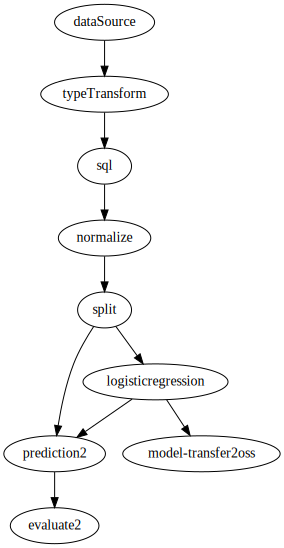

In [10]:
p.dot()